In [1]:
%load_ext autoreload
%autoreload 1

import json
import os
import pickle
import time
import timeit
import random
import socket
import struct

import numpy as np
import pandas as pd
import networkx as nx

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import class_weight

from src.calculate_FPR_FNR import calculate_FPR_FNR_with_global
from src.dataset.dataset_info import datasets, cn_measures, network_features
import src.models as models
import src.models_gdlc_keras as gdlc_models
# from src.models import EGAT, EGCN, EGRAPHSAGE, Model
from src.plot_confusion_matrix import plot_confusion_matrix
from src.graph.centralities.add_centralities import add_centralities
from src.graph.graph_measures import calculate_graph_measures, find_communities

%aimport src.models

num_epochs = 5
batch_size = 1024
learning_rate = 0.001
LAMBD_1 = 0.0001
LAMBD_2 = 0.001
validation_size = 0.1
test_size = 0.1

In [2]:
# name = "cic_ton_iot_5_percent"
# name = "cic_ton_iot"
# name = "cic_ids_2017_5_percent"
name = "cic_ids_2017"
# name = "cic_bot_iot"
# name = "cic_ton_iot_modified"
# name = "nf_ton_iotv2_modified"
# name = "ccd_inid_modified"
# name = "nf_uq_nids_modified"
# name = "edge_iiot"
# name = "nf_cse_cic_ids2018"
# name = "nf_bot_iotv2"
# name = "nf_uq_nids"
# name = "x_iiot"

with_centralities = True
centralities_set = 1

multi_class = True

# dataset properties
use_port_in_address = False
generated_ips = False

graph_type = "flow"
# graph_type = "line"

using_masking = False
masked_class = True

sort_timestamp = False

sort_after_partition = True
sequence_length = 1
stride = 1

dataset = datasets[name]

dataset_folder = os.path.join("datasets", name)
dataset_folder

'datasets\\cic_ids_2017'

In [3]:
labels = ["Normal", "Attack"]
num_classes = 2
if multi_class:
    with open(os.path.join(dataset_folder, "labels_names.pkl"), "rb") as f:
        labels_names = pickle.load(f)
    labels_mapping = labels_names[0]
    # labels = labels_names[1]
    labels = list(labels_mapping.values())
    num_classes = len(labels)
labels, num_classes

([np.str_('BENIGN'),
  np.str_('Bot'),
  np.str_('DDoS'),
  np.str_('DoS GoldenEye'),
  np.str_('DoS Hulk'),
  np.str_('DoS Slowhttptest'),
  np.str_('DoS slowloris'),
  np.str_('FTP-Patator'),
  np.str_('Heartbleed'),
  np.str_('Infiltration'),
  np.str_('PortScan'),
  np.str_('SSH-Patator'),
  np.str_('Web Attack � Brute Force'),
  np.str_('Web Attack � Sql Injection'),
  np.str_('Web Attack � XSS')],
 15)

In [4]:
out_channels_list = [16, 32, 64]
rnn_num_layers = 2
rnn_hidden_size = 64
dropout=0.3

In [5]:
exp_type = f"gdlc__{graph_type}"
    
if multi_class:
    exp_type += "__multi_class"
    
# if k_fold:
#     exp_type += f"__{k_fold}_fold"
    
if use_port_in_address:
    exp_type += "__ports"
    
if generated_ips:
    exp_type += "__generated_ips"
    
if sort_timestamp:
    exp_type += "__sorted"
elif sort_after_partition:
    exp_type += "__semisorted"
else:
    exp_type += "__unsorted"

In [6]:
results_final = {}

results_final["name"] = name
results_final["exp_type"] = exp_type
results_final["configuration"] = {
    "num_epochs": num_epochs,
    "multi_class": multi_class,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "with_centralities": with_centralities,
    "centralities_set": centralities_set,
    "use_port_in_address": use_port_in_address,
    "generated_ips": generated_ips,
    "using_masking": using_masking,
    "masked_class_num": masked_class,
    "sequence_length": sequence_length,
    "LAMBD_1": LAMBD_1,
    "LAMBD_2": LAMBD_2
}

results_final["accuracy"] = {}
results_final["f1_score"] = {}
results_final["FPR"] = {}
results_final["FNR"] = {}
results_final["time_elapsed"] = {}
results_final["train_accuracy"] = {}
results_final["train_loss"] = {}
results_final["val_accuracy"] = {}
results_final["val_loss"] = {}
results_final["val_precision"] = {}
results_final["val_recall"] = {}
results_final["val_f1"] = {}
results_final["val_FPR"] = {}
results_final["val_FNR"] = {}


results_final

{'name': 'cic_ids_2017',
 'exp_type': 'gdlc__flow__multi_class__semisorted',
 'configuration': {'num_epochs': 5,
  'multi_class': True,
  'batch_size': 1024,
  'learning_rate': 0.001,
  'with_centralities': True,
  'centralities_set': 1,
  'use_port_in_address': False,
  'generated_ips': False,
  'using_masking': False,
  'masked_class_num': True,
  'sequence_length': 1,
  'LAMBD_1': 0.0001,
  'LAMBD_2': 0.001},
 'accuracy': {},
 'f1_score': {},
 'FPR': {},
 'FNR': {},
 'time_elapsed': {},
 'train_accuracy': {},
 'train_loss': {},
 'val_accuracy': {},
 'val_loss': {},
 'val_precision': {},
 'val_recall': {},
 'val_f1': {},
 'val_FPR': {},
 'val_FNR': {}}

In [7]:
dtime = time.strftime("%Y%m%d-%H%M%S")
dtime

'20250115-145711'

In [8]:
results_folder_path = "results"
results_folder_path1 = os.path.join(results_folder_path, name)
results_folder_path2 = os.path.join(results_folder_path1, exp_type)
folder_path = os.path.join(results_folder_path2, dtime)
confusion_matrices_path = os.path.join(folder_path, "confusion_matrices")
os.makedirs(confusion_matrices_path, exist_ok=True)

In [9]:
if using_masking:
    results_final["configuration"]["masked_class_name"] = str(labels[masked_class])

In [10]:
new_folder_path = os.path.join(dataset_folder, exp_type)
temp_folder_path = os.path.join(dataset_folder, exp_type + "_temp")

In [11]:
partitioned = os.path.isfile(f"{temp_folder_path}/train.pkl") and os.path.isfile(f"{temp_folder_path}/val.pkl") and os.path.isfile(f"{temp_folder_path}/test.pkl")
partitioned

True

In [12]:
calculated_centralities = os.path.isfile(os.path.join(new_folder_path, "training.parquet")) and os.path.isfile(os.path.join(new_folder_path, "validation.parquet")) and os.path.isfile(os.path.join(new_folder_path, "testing.parquet"))
calculated_centralities

True

In [13]:
if calculated_centralities:
    X_train = pd.read_parquet(os.path.join(new_folder_path, "training.parquet"))
    X_val = pd.read_parquet(os.path.join(new_folder_path, "validation.parquet"))
    X_test = pd.read_parquet(os.path.join(new_folder_path, "testing.parquet"))
elif partitioned:
    with open(os.path.join(temp_folder_path, "train.pkl"), "rb") as f:
        X_train, G_train, G1_train, communities_train, part_train = pickle.load(f)

    with open(os.path.join(temp_folder_path, "val.pkl"), "rb") as f:
        X_val, G_val, G1_val, communities_val, part_val = pickle.load(f)

    with open(os.path.join(temp_folder_path, "test.pkl"), "rb") as f:
        X_test, G_test, G1_test, communities_test, part_test = pickle.load(f)
elif with_centralities:
    df = pd.read_parquet(os.path.join(dataset_folder, f"{name}.parquet"))
    if generated_ips:
        df[dataset.src_ip_col] = df[dataset.src_ip_col].apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))
    if sort_timestamp:
        df[dataset.timestamp_col] = pd.to_datetime(df[dataset.timestamp_col].str.strip(), format=dataset.timestamp_format)
        df.sort_values(dataset.timestamp_col, inplace=True)
    if use_port_in_address:
        df[dataset.src_port_col] = df[dataset.src_port_col].astype(float).astype(int).astype(str) # to remove the decimal point
        df[dataset.src_ip_col] = df[dataset.src_ip_col] + ':' + df[dataset.src_port_col]

        df[dataset.dst_port_col] = df[dataset.dst_port_col].astype(float).astype(int).astype(str) # to remove the decimal point
        df[dataset.dst_ip_col] = df[dataset.dst_ip_col] + ':' + df[dataset.dst_port_col]
    if multi_class:
        y = df[dataset.class_num_col]
    else:
        y = df[dataset.label_col]

    if sort_timestamp:
        X_tr, X_test, y_tr, y_test = train_test_split(
            df, y, test_size=test_size)
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_tr, y_tr, test_size=validation_size)
    else:
        X_tr, X_test, y_tr, y_test = train_test_split(
            df, y, test_size=test_size, random_state=13, stratify=y)
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_tr, y_tr, test_size=validation_size, random_state=13, stratify=y_tr)

    del df

    if sort_after_partition:
        X_train[dataset.timestamp_col] = pd.to_datetime(X_train[dataset.timestamp_col].str.strip(), format=dataset.timestamp_format)
        X_train.sort_values(dataset.timestamp_col, inplace=True)

        X_val[dataset.timestamp_col] = pd.to_datetime(X_val[dataset.timestamp_col].str.strip(), format=dataset.timestamp_format)
        X_val.sort_values(dataset.timestamp_col, inplace=True)
        
        X_test[dataset.timestamp_col] = pd.to_datetime(X_test[dataset.timestamp_col].str.strip(), format=dataset.timestamp_format)
        X_test.sort_values(dataset.timestamp_col, inplace=True)

    if using_masking:
        X_train = X_train[X_train[dataset.class_num_col] != masked_class]

    G_train = nx.from_pandas_edgelist(
        X_train, source=dataset.src_ip_col, target=dataset.dst_ip_col, create_using=nx.DiGraph)
    G_train.remove_nodes_from(list(nx.isolates(G_train)))
    for node in G_train.nodes():
        G_train.nodes[node]['label'] = node
    G1_train, part_train, communities_train = find_communities(G_train, verbose=True)
    calculate_graph_measures(G_train, communities=communities_train, verbose=True)

    G_val = nx.from_pandas_edgelist(
        X_val, source=dataset.src_ip_col, target=dataset.dst_ip_col, create_using=nx.DiGraph)
    G_val.remove_nodes_from(list(nx.isolates(G_val)))
    for node in G_val.nodes():
        G_val.nodes[node]['label'] = node
    G1_val, part_val, communities_val = find_communities(G_val, verbose=True)
    calculate_graph_measures(G_val, communities=communities_val, verbose=True)

    G_test = nx.from_pandas_edgelist(
        X_test, source=dataset.src_ip_col, target=dataset.dst_ip_col, create_using=nx.DiGraph)
    G_test.remove_nodes_from(list(nx.isolates(G_test)))
    for node in G_test.nodes():
        G_test.nodes[node]['label'] = node
    G1_test, part_test, communities_test = find_communities(G_test, verbose=True)
    calculate_graph_measures(G_test, communities=communities_test, verbose=True)

    os.makedirs(temp_folder_path, exist_ok=True)

    with open(os.path.join(temp_folder_path, "train.pkl"), "wb") as f:
        pickle.dump((X_train, G_train, G1_train, communities_train, part_train), f)

    with open(os.path.join(temp_folder_path, "val.pkl"), "wb") as f:
        pickle.dump((X_val, G_val, G1_val, communities_val, part_val), f)

    with open(os.path.join(temp_folder_path, "test.pkl"), "wb") as f:
        pickle.dump((X_test, G_test, G1_test, communities_test, part_test), f)

else:
    df = pd.read_parquet(os.path.join(dataset_folder, f"{name}.parquet"))
    if generated_ips:
        df[dataset.src_ip_col] = df[dataset.src_ip_col].apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))
    if sort_timestamp:
        df[dataset.timestamp_col] = pd.to_datetime(df[dataset.timestamp_col].str.strip(), format=dataset.timestamp_format)
        df.sort_values(dataset.timestamp_col, inplace=True)
    if use_port_in_address:
        df[dataset.src_port_col] = df[dataset.src_port_col].astype(float).astype(int).astype(str) # to remove the decimal point
        df[dataset.src_ip_col] = df[dataset.src_ip_col] + ':' + df[dataset.src_port_col]

        df[dataset.dst_port_col] = df[dataset.dst_port_col].astype(float).astype(int).astype(str) # to remove the decimal point
        df[dataset.dst_ip_col] = df[dataset.dst_ip_col] + ':' + df[dataset.dst_port_col]
    if multi_class:
        y = df[dataset.class_num_col]
    else:
        y = df[dataset.label_col]

    if sort_timestamp:
        X_tr, X_test, y_tr, y_test = train_test_split(
            df, y, test_size=test_size)
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_tr, y_tr, test_size=validation_size)
    else:
        X_tr, X_test, y_tr, y_test = train_test_split(
            df, y, test_size=test_size, random_state=13, stratify=y)
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_tr, y_tr, test_size=validation_size, random_state=13, stratify=y_tr)

    del df

In [14]:
if with_centralities and not calculated_centralities:
    centralities_set = 2
    %autoreload
    os.makedirs(new_folder_path, exist_ok=True)
    add_centralities(df = X_train, new_path=os.path.join(new_folder_path, "training.parquet"), graph_path=None, dataset=dataset, cn_measures=cn_measures[centralities_set-1], network_features=network_features[centralities_set-1], G=G_train, communities=communities_train, G1=G1_train, part=part_train)
    print("===================")
    print("validation:")
    add_centralities(df = X_val, new_path=os.path.join(new_folder_path, "validation.parquet"), graph_path=None, dataset=dataset, cn_measures=cn_measures[centralities_set-1], network_features=network_features[centralities_set-1], G=G_val, communities=communities_val, G1=G1_val, part=part_val)
    print("===================")
    print("testing:")
    add_centralities(df = X_test, new_path=os.path.join(new_folder_path, "testing.parquet"), graph_path=None, dataset=dataset, cn_measures=cn_measures[centralities_set-1], network_features=network_features[centralities_set-1], G=G_test, communities=communities_test, G1=G1_test, part=part_test)

In [15]:
if multi_class:
    y_train = X_train[dataset.class_num_col]
    y_val = X_val[dataset.class_num_col]
    y_test = X_test[dataset.class_num_col]
else:
    y_train = X_train[dataset.label_col]
    y_val = X_val[dataset.label_col]
    y_test = X_test[dataset.label_col]

In [16]:
cols_to_norm = list(set(list(X_train.columns))  - set(list([dataset.label_col, dataset.class_num_col])) - set(dataset.drop_columns)  - set(dataset.weak_columns))
if not with_centralities and partitioned:
    cols_to_norm = list(set(list(X_train.columns))  - set(list([dataset.label_col, dataset.class_num_col])) - set(dataset.drop_columns)  - set(dataset.weak_columns) - set(network_features[centralities_set-1]))
# cols_to_norm = list(set(list(X_train.columns))  - set(list([dataset.label_col, dataset.class_num_col])) - set(dataset.drop_columns)  - set(dataset.weak_columns))
cols_to_norm

['dst_closeness',
 'src_degree',
 'Flow IAT Min',
 'Fwd Seg Size Avg',
 'Init Bwd Win Byts',
 'dst_mv',
 'src_betweenness',
 'dst_degree',
 'ECE Flag Cnt',
 'dst_betweenness',
 'dst_k_truss',
 'dst_pagerank',
 'Bwd Seg Size Avg',
 'Bwd IAT Tot',
 'SYN Flag Cnt',
 'src_global_betweenness',
 'Bwd Header Len',
 'Bwd Pkts/s',
 'dst_global_pagerank',
 'src_global_pagerank',
 'src_closeness',
 'Fwd Pkts/s',
 'PSH Flag Cnt',
 'URG Flag Cnt',
 'ACK Flag Cnt',
 'Fwd Header Len',
 'Active Max',
 'src_eigenvector',
 'dst_global_degree',
 'FIN Flag Cnt',
 'Init Fwd Win Byts',
 'dst_global_betweenness',
 'Flow Byts/s',
 'Bwd IAT Min',
 'src_global_degree',
 'src_mv',
 'Idle Std',
 'CWE Flag Count',
 'src_k_truss',
 'Fwd Seg Size Min',
 'Subflow Fwd Byts',
 'Bwd Pkt Len Min',
 'Down/Up Ratio',
 'Bwd IAT Max',
 'src_pagerank',
 'Active Min',
 'Fwd Act Data Pkts',
 'src_k_core',
 'Idle Min',
 'dst_eigenvector',
 'Pkt Len Min',
 'dst_k_core',
 'Fwd Pkt Len Min']

In [17]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train[cols_to_norm])
X_val = scaler.transform(X_val[cols_to_norm])
X_test = scaler.transform(X_test[cols_to_norm])

In [18]:
X_train.shape

(2280051, 53)

In [19]:
class CnnDataset(Dataset):
    def __init__(self, X, y):
        self.X = th.tensor(X, dtype=th.float32)  # shape: (N, num_features)
        self.y = th.tensor(y, dtype=th.long)     # shape: (N,)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x_sample = self.X[idx]           # shape: (num_features,)
        x_sample = x_sample.unsqueeze(0) # shape: (1, num_features) => 1 channel
        y_sample = self.y[idx]
        return x_sample, y_sample

In [20]:
class SlidingWindowDataset(Dataset):
    def __init__(self, data, targets, seq_length=10, stride=1, transform=None):
        """
        data:    array-like shape (N, num_features), or path to data that can be loaded in slices
        targets: array-like shape (N,) or (N, num_targets)
        seq_length (int): number of timesteps in each sequence
        stride (int): step size between consecutive windows
        transform (callable): optional transform to apply on each window
        """
        super().__init__()
        self.data = data
        self.targets = targets
        self.seq_length = seq_length
        self.stride = stride
        self.transform = transform
        
        # Number of sequences we can form
        # e.g. if stride=1, we can form (len(data) - seq_length + 1) windows
        self.num_sequences = (len(self.data) - seq_length) // stride + 1
        assert self.num_sequences > 0, "Not enough data to form even one sequence!"

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        """
        Generate the sliding window sequence on-the-fly:
          window indices: [start_idx : start_idx + seq_length)
          label index:    e.g. the last step in that window (or next step, depending on your task)
        """
        start_idx = idx * self.stride
        end_idx = start_idx + self.seq_length
        
        # Get the sequence
        x_seq = self.data[start_idx:end_idx]  # shape: (seq_length, num_features)
        
        # For classification, you might take target at the last step in the window
        # or the step right after the window. Adjust as needed:
        y_label = self.targets[end_idx - 1]  # last step’s label, for example
        
        # If you need to transform or reshape x_seq (e.g., for CNN => (1, seq_length)), do it here
        if self.transform:
            x_seq = self.transform(x_seq)
        
        # Convert to torch tensors, if not already
        x_seq = th.as_tensor(x_seq, dtype=th.float32)
        y_label = th.as_tensor(y_label, dtype=th.long)
        
        return x_seq, y_label

In [21]:
class_weights = class_weight.compute_class_weight('balanced',
                                                classes=np.unique(y_train.to_numpy()),
                                                y=y_train.to_numpy())
if using_masking:
    class_weights=np.insert(class_weights, masked_class, 0)
    
class_weights = th.FloatTensor(class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [22]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [23]:
def train_model(model, X_training, y_training, X_validation, y_validation):

    model.build()
    history = model.train(X_training, y_training, X_validation, y_validation)
    
    training_loss = history.history['loss']            # training loss for each epoch
    training_acc  = history.history['accuracy']        # training accuracy for each epoch
    val_loss      = history.history['val_loss']        # validation loss for each epoch
    val_acc       = history.history['val_accuracy']    # validation accuracy for each epoch

    results_final["train_loss"][model.model_name()] = training_loss
    results_final["train_accuracy"][model.model_name()] = training_acc
    results_final["val_loss"][model.model_name()] = val_loss
    results_final["val_accuracy"][model.model_name()] = val_acc
        
    return model

In [24]:
def test_model(model, X_testing, y_testing):
        
    print("=======================")
    print(f"testing model: {model.model_name()}")
    
    predictions, prediction_time = model.predict(X_testing)
    model_name, scores, class_report, actual, test_pred, cm_new, cm_normalized, results_fpr_fnr = model.evaluate(  # type: ignore
            predictions,
            y_testing,
            prediction_time,
            labels_names = labels,
            labels_dict = labels_names[0]
        )
    print(f"==>> scores: {scores}")
    # Log metrics
    results_final[model.model_name()]["elapsed"] = scores["time"]
    results_final[model.model_name()]["classification_report"] = class_report
    results_final["accuracy"][model.model_name()] = scores["accuracy"]
    results_final["f1_score"][model.model_name()] = scores['f1s']
    results_final["FPR"][model.model_name()] = scores['FPR']
    results_final["FNR"][model.model_name()] = scores['FNR']
    results_final["time_elapsed"][model.model_name()] = scores["time"]

    # print(classification_report(actual, test_pred, digits=4, zero_division=0))
    
    return actual, test_pred, cm_new, cm_normalized


In [25]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

In [31]:
%autoreload

In [32]:
num_classes

15

In [33]:
my_models = [
    # gdlc_models.MyCNN(
    #     input_dim=X_train.shape[-1],
    #     dataset_name=dataset.name,
    #     num_classes=num_classes,
    #     multi_class=multi_class,
    #     network_features=network_features[centralities_set - 1],
    #     epochs=num_epochs,
    #     batch_size=batch_size,
    #     early_stop_patience=10,
    # ),
    gdlc_models.MyLSTM(
        sequence_length=sequence_length,
        input_dim=X_train.shape[-1],
        dataset_name=dataset.name,
        num_classes=num_classes,
        multi_class=multi_class,
        network_features=network_features[centralities_set - 1],
        use_generator=True,
        epochs=num_epochs,
        batch_size=batch_size,
        early_stop_patience=10,
    ),
    gdlc_models.MyGRU(
        sequence_length=sequence_length,
        input_dim=X_train.shape[-1],
        dataset_name=dataset.name,
        num_classes=num_classes,
        multi_class=multi_class,
        network_features=network_features[centralities_set - 1],
        use_generator=True,
        epochs=num_epochs,
        batch_size=batch_size,
        early_stop_patience=10,
    )
]

In [34]:
for m in my_models:
    results_final[m.model_name()] = {}
    results_final["accuracy"][m.model_name()] = []
    results_final["time_elapsed"][m.model_name()] = []
    results_final["train_accuracy"][m.model_name()] = []
    results_final["train_loss"][m.model_name()] = []
    results_final["val_accuracy"][m.model_name()] = []
    results_final["val_loss"][m.model_name()] = []
    results_final["val_precision"][m.model_name()] = []
    results_final["val_recall"][m.model_name()] = []
    results_final["val_f1"][m.model_name()] = []
    results_final["val_FPR"][m.model_name()] = []
    results_final["val_FNR"][m.model_name()] = []

53


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 80)             │        42,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │         8,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         1,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,215 (207.87 KB)

 Trainable params: 52,855 (206.46 KB)

 Non-trainable params: 360 (1.41 KB)

Epoch 1/5
2226/2227 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8982 - loss: 1.1953
Epoch 1: val_loss improved from inf to 1.88690, saving model to temp/best_model_lstm.keras
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 99s 43ms/step - accuracy: 0.8982 - loss: 1.1948 - val_accuracy: 0.6348 - val_loss: 1.8869
Epoch 2/5
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9807 - loss: 0.1404
Epoch 2: val_loss did not improve from 1.88690
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 99s 44ms/step - accuracy: 0.9807 - loss: 0.1405 - val_accuracy: 0.6177 - val_loss: 2.3918
Epoch 3/5
2226/2227 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9809 - loss: 0.1325
Epoch 3: val_loss improved from 1.88690 to 1.59691, saving model to temp/best_model_lstm.keras
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 91s 41ms/step - accuracy: 0.9809 - loss: 0.1326 - val_accuracy: 0.7045 - val_loss: 1.5969
Epoch 4/5
2226/2227 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9822 - loss: 0.1206
Epoch 4: val_loss did not improve from 1.59691
2227/

c:\Users\Administrateur\Desktop\GNN-NIDS\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrateur\Desktop\GNN-NIDS\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrateur\Desktop\GNN-NIDS\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

confusion_matrix:
[[218884      0      0      0   7705      0      0      0      0      0
       2      0      0      0      0]
 [   196      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [ 12803      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [  1029      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [ 22256      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [   550      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [   577      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [   793      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     1      0      0      0      0      0      0      0      0      0
       0      0      0      0 

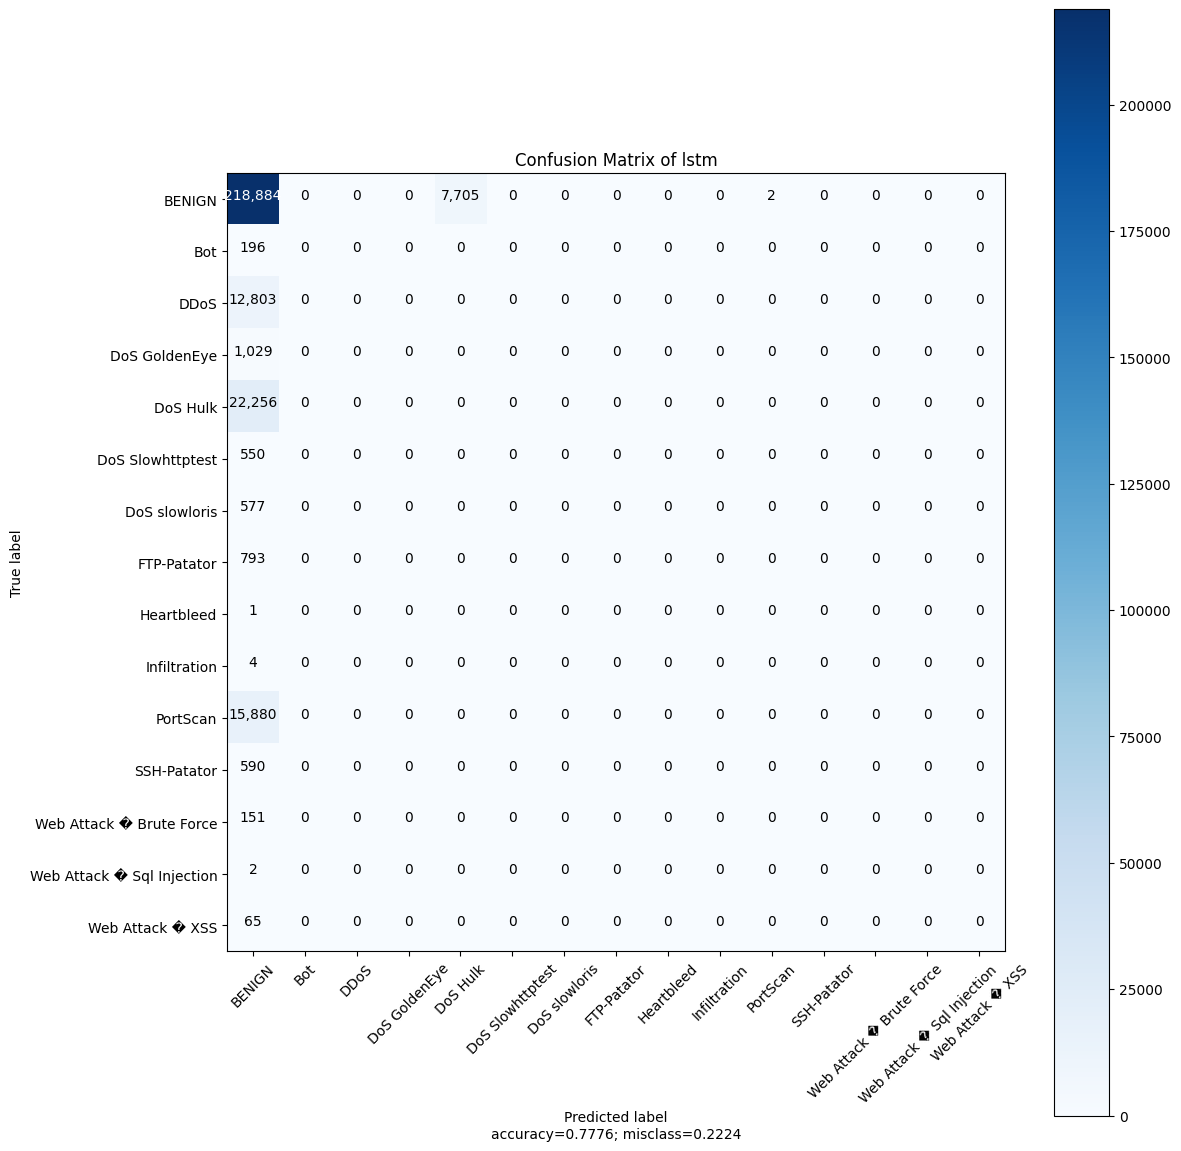

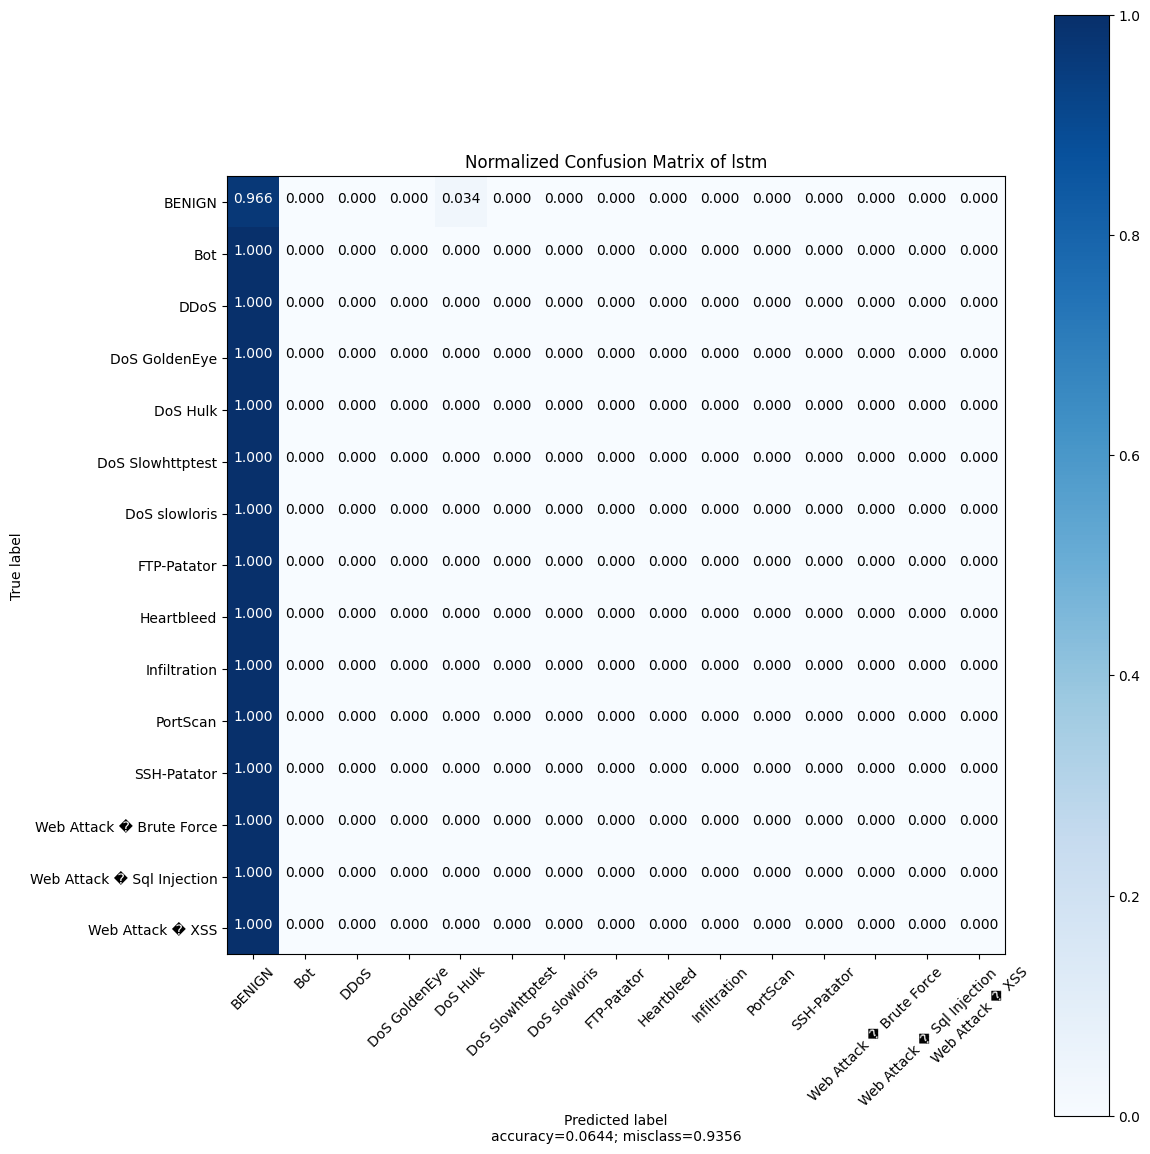

==>> LAMBD: 0.01
==>> datetime.datetime: <class 'datetime.datetime'>
53


c:\Users\Administrateur\Desktop\GNN-NIDS\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 80)             │        32,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │         8,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │         1,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,735 (166.93 KB)

 Trainable params: 42,375 (165.53 KB)

 Non-trainable params: 360 (1.41 KB)

Epoch 1/5
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8996 - loss: 0.8620
Epoch 1: val_loss improved from inf to 2.26028, saving model to temp/best_model_gru.keras
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 99s 42ms/step - accuracy: 0.8996 - loss: 0.8618 - val_accuracy: 0.7323 - val_loss: 2.2603
Epoch 2/5
2226/2227 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9803 - loss: 0.1412
Epoch 2: val_loss improved from 2.26028 to 1.43473, saving model to temp/best_model_gru.keras
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 91s 41ms/step - accuracy: 0.9803 - loss: 0.1413 - val_accuracy: 0.7438 - val_loss: 1.4347
Epoch 3/5
2226/2227 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9830 - loss: 0.1220
Epoch 3: val_loss improved from 1.43473 to 1.37817, saving model to temp/best_model_gru.keras
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 91s 41ms/step - accuracy: 0.9830 - loss: 0.1221 - val_accuracy: 0.8050 - val_loss: 1.3782
Epoch 4/5
2226/2227 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9815 - loss: 0.1284
Epoch 4

c:\Users\Administrateur\Desktop\GNN-NIDS\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrateur\Desktop\GNN-NIDS\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrateur\Desktop\GNN-NIDS\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

confusion_matrix:
[[213660      0  12914      0      0      0      0      0      0     17
       0      0      0      0      0]
 [   185      0     11      0      0      0      0      0      0      0
       0      0      0      0      0]
 [ 12803      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [  1029      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [ 22256      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [   550      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [   577      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [   793      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     1      0      0      0      0      0      0      0      0      0
       0      0      0      0 

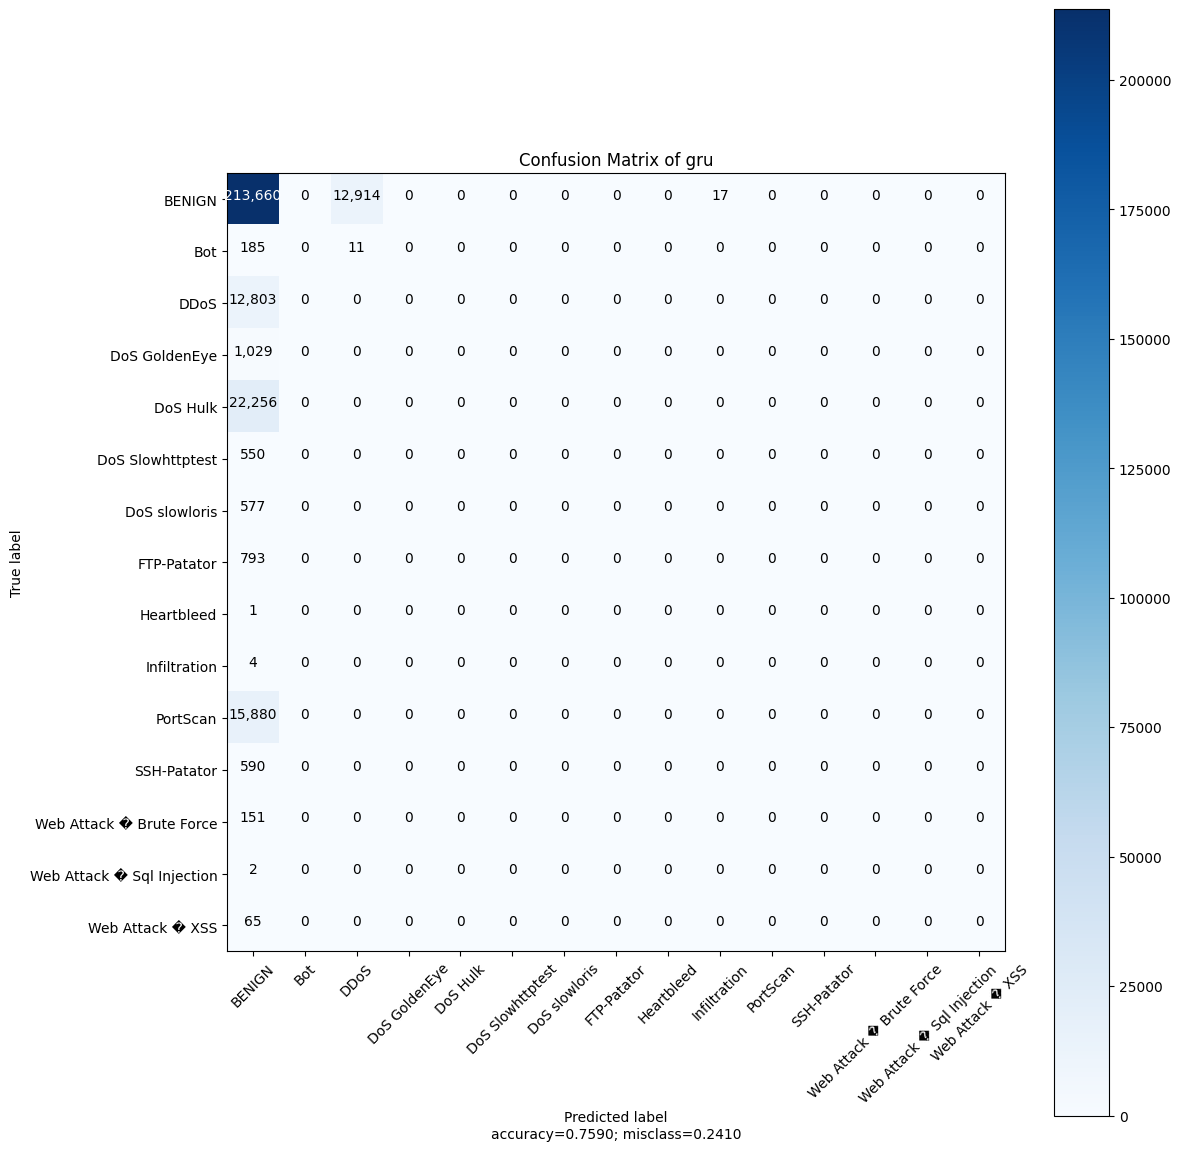

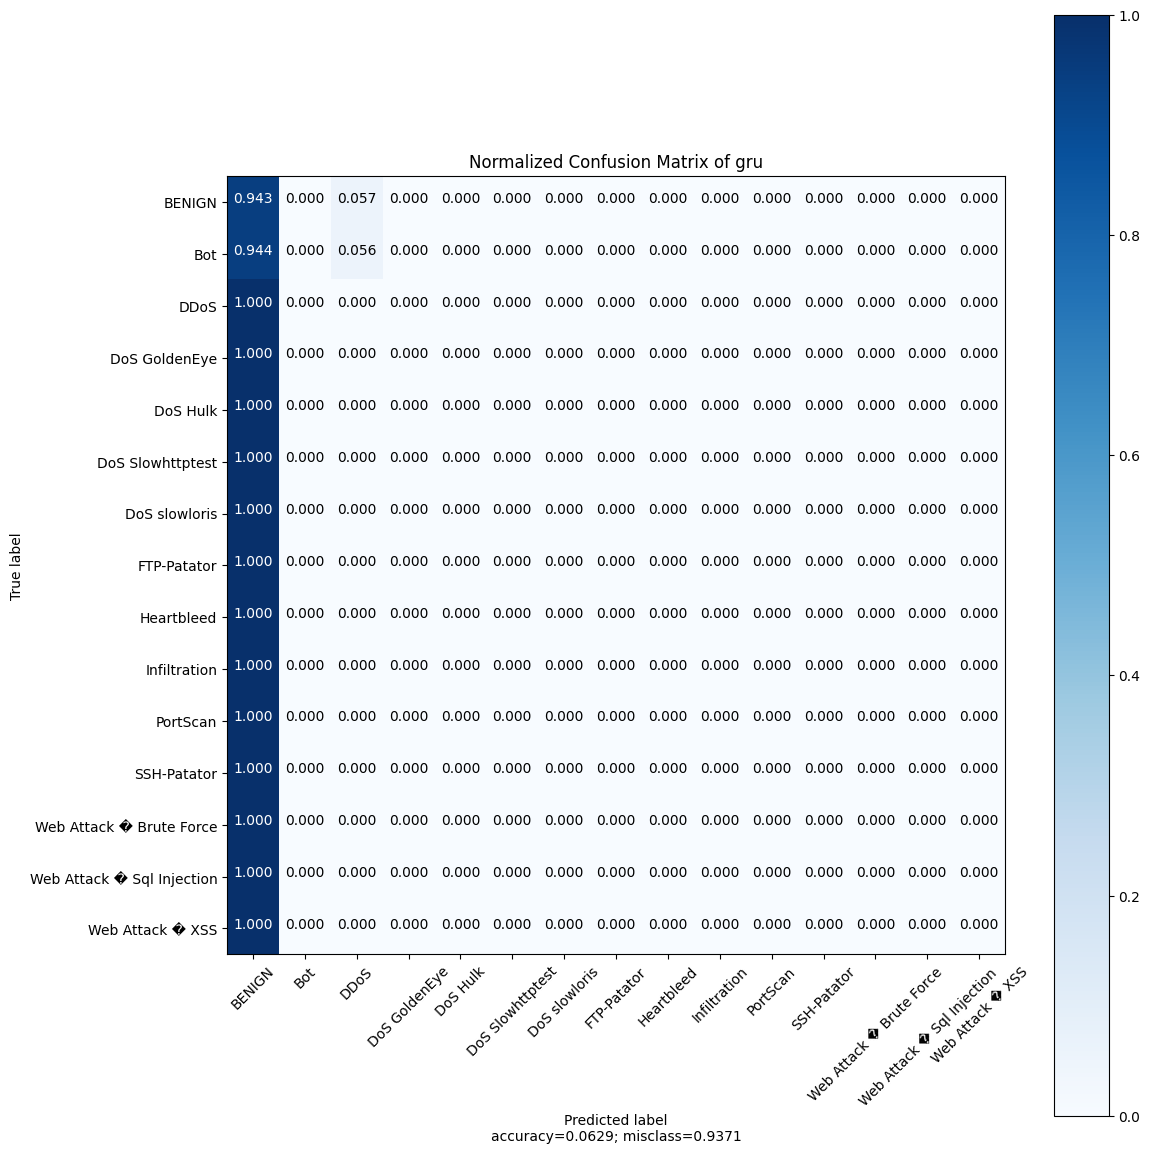

In [35]:
for m in my_models:
    train_model(m, X_train,
                y_train.to_numpy(),
                X_val,
                y_val.to_numpy())
    actual, test_pred, cm, cm_normalized = test_model(m, X_test, y_test.to_numpy())
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title=f"Confusion Matrix of {m.model_name()}",
                          file_path=f"{confusion_matrices_path}/{m.model_name()}.png")
    
    plot_confusion_matrix(cm=cm_normalized,
                          normalize=False,
                          normalized=True,
                          target_names=labels,
                          title=f"Normalized Confusion Matrix of {m.model_name()}",
                          file_path=f"{confusion_matrices_path}/{m.model_name()}_normalized.png")
    
    with open(os.path.join(folder_path, "actual.json"), "w") as f:
        f.writelines(json.dumps(actual, cls=NumpyEncoder))
        
    with open(os.path.join(folder_path, f"{m.model_name()}_pred.json"), "w") as f:
        f.writelines(json.dumps(test_pred, cls=NumpyEncoder))
        
    with open(os.path.join(folder_path, "results.json"), "w") as f:
        f.writelines(json.dumps(results_final, cls=NumpyEncoder))